In [1]:
# jupyter-notebook V0_1_1.ipynb --port 8888 --ip 192.168.1.5

import cv2
import os
import numpy as np
from collections import Counter
import itertools  
from collections import defaultdict
import time
import numba as nb
import copy
from os import listdir, mkdir
from os.path import isfile, isdir, join

from components_container import ComponentsContainer

%matplotlib inline

In [2]:
# filter all noise using minimum size threshold
BACKGROUND_INTENSITY_THRESHOLD = 20
MIN_AXON_SIZE = 20

# merging close components based on centroids and contour distance
PREMERGE_CENTROIDS_DISTANCE_T  = 200
PREMERGE_CONTOUR_DISTANCE_T = 15

#splitting nucleus and axons based on size
MIN_NUCLEUS_SIZE = 150

#grouping possible axons to nucleus
CENTROIDS_DISTANCE_T = 90
CONTOUR_DISTANCE_T = 25

LOADPATH = '../raw_pics'
SAVEPATH = '../info'
RECURSIVE = True

In [3]:
def mirror_dir_for_save(loadpath):
    try:
        mkdir(loadpath.replace(LOADPATH, SAVEPATH))
    except(OSError):
        pass
    
def process_dir(loadpath):
    mirror_dir_for_save(loadpath)
    object_names_in_folder = listdir(loadpath)
    print ("start processing folder {} pics: {}".format(loadpath, str(len(object_names_in_folder))))
    for f in object_names_in_folder:
        local_object = join(loadpath, f)

        if isfile(local_object) and f[0] != '.':
            process_pic(join(loadpath, f))
            continue

        if RECURSIVE and isdir(join(loadpath, f)):
            process_dir(join(loadpath, f))
            continue

def process_pic(path):
    starttime = time.time()
    print("processing pic {} ...".format(path), end = "")
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, BACKGROUND_INTENSITY_THRESHOLD, 400, cv2.THRESH_BINARY)
    container = ComponentsContainer(binary, MIN_AXON_SIZE)
    container.merge_components_closer_than(PREMERGE_CENTROIDS_DISTANCE_T, PREMERGE_CONTOUR_DISTANCE_T)
    container.recalc_edge_and_size_info()    
    container.split_nucl_axon(MIN_NUCLEUS_SIZE)
    container.group_axons_to_nucleus(CENTROIDS_DISTANCE_T, CONTOUR_DISTANCE_T)
    with open(path.replace(LOADPATH, SAVEPATH).replace(".bmp", ".txt"), "w") as f:
        write_info_from_container(container, f)
    save_pic_from_container(container,path.replace(LOADPATH, SAVEPATH).replace(".bmp", "_processed.png"))
    print('done in {} sec.'.format(time.time() - starttime))


def write_info_from_container(container, f):
    labs = sorted(container.nucleus_labs, key = lambda x: -container.components_index.get(x).size)
    f.write("#, Size, Perimeter, P/S\n")
    i = 0
    for nucl_lab in labs:
        i +=1
        nucl = container.components_index.get(nucl_lab)
        f.write("{:2}, {:4}, {:4}, {:.3}\n".format(i, nucl.size, len(nucl.edge), len(nucl.edge)/nucl.size))
        
def save_pic_from_container(container, savepath):
    pic = container.get_nucl_and_axons_img()
    cv2.imwrite(savepath,pic)

In [4]:
#LOADPATH = '../raw_pics/hippo/с4_6_73'
process_dir(LOADPATH)

start processing folder ../raw_pics/hippo/с4_6_73 pics: 34
processing pic ../raw_pics/hippo/с4_6_73/c4_6_73_hippo1.bmp ...done in 49.63247108459473 sec.
processing pic ../raw_pics/hippo/с4_6_73/c4_6_73_hippo10.bmp ...done in 42.88567519187927 sec.
processing pic ../raw_pics/hippo/с4_6_73/c4_6_73_hippo11.bmp ...

KeyboardInterrupt: 

In [99]:
# testing

img = cv2.imread('../raw_pics/hippo/с4_6_73/c4_6_73_hippo21.bmp')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, BACKGROUND_INTENSITY_THRESHOLD, 400, cv2.THRESH_BINARY)
container = ComponentsContainer(binary, MIN_AXON_SIZE)
container.merge_components_closer_than(PREMERGE_CENTROIDS_DISTANCE_T, PREMERGE_CONTOUR_DISTANCE_T)
container.split_nucl_axon(MIN_NUCLEUS_SIZE)
container.group_axons_to_nucleus(CENTROIDS_DISTANCE_T, CONTOUR_DISTANCE_T)

True

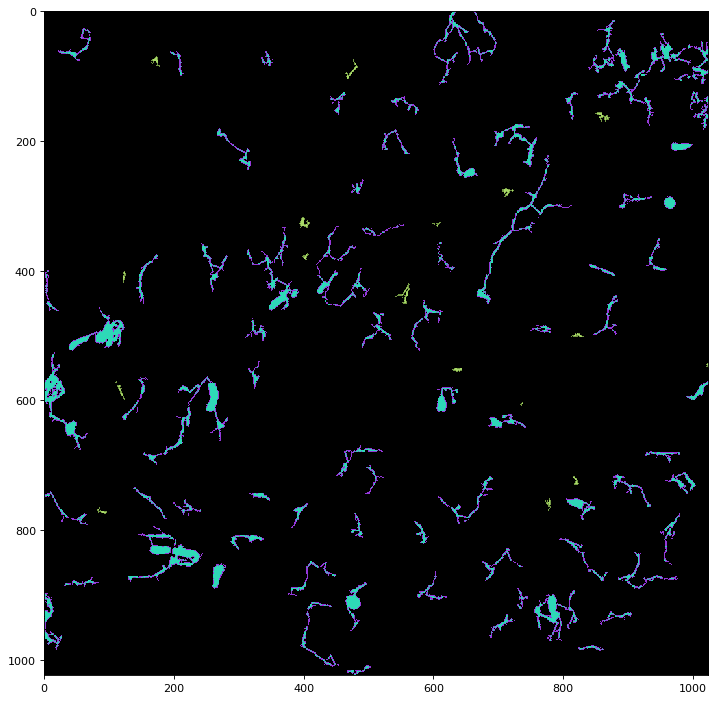

In [105]:
from matplotlib import pyplot as plt
self = container
pic = np.zeros((*self.markers.shape,3))
nucl_color = [210,40,73]
axon_color = [88,40,153]
n_edge_color = [108,200,38]
a_edge_color = [140,103,189]

for nucl_lab in self.nucleus_labs:
    pic[self.markers == nucl_lab] = nucl_color
    for ax in self.components_index.get(nucl_lab).axons:
        pic[self.markers == ax.label] = axon_color
        for ed in ax.edge:
            pic[ed[0], ed[1]] = a_edge_color
    for ed in self.components_index.get(nucl_lab).edge:
        pic[ed[0], ed[1]] = n_edge_color
        
    

    
fig = plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(pic)

cv2.imwrite('../test.bmp',pic)

